In [1]:
import time
from options.train_options import TrainOptions
from data import create_dataset
from models import create_model
from util.visualizer import Visualizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

%matplotlib inline

from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid

datadir = '/home/user/data/twins'

In [2]:
metadata = pd.read_csv(f'{datadir}/image-metadata-2.0.csv')

# filter 
metadata = metadata[(metadata[' yaw']==0)&(metadata[' expression']!=' Happiness')&(metadata[' glasses']==' none')]
metadata['person_id'] = metadata['filename'].apply(lambda x: int(x.split('d')[0]))
metadata['view_id'] = metadata['filename'].apply(lambda x: x.split('d')[1].split('.')[0])
metadata.head()

,filename,date,gender,race,yearofbirth,weather,glasses,expression,yaw,Unnamed: 9,person_id,view_id
16,90003d17.nef,2009-08-08 00:00:00,Male,Black-or-African-American,1970,Inside,none,BlankStare,0,90003d17.nef,90003,17
17,90003d18.nef,2009-08-08 00:00:00,Male,Black-or-African-American,1970,Inside,none,BlankStare,0,90003d18.nef,90003,18
36,90003d40.nef,2009-08-08 00:00:00,Male,Black-or-African-American,1970,Inside,none,BlankStare,0,90003d40.nef,90003,40
38,90003d42.nef,2009-08-08 00:00:00,Male,Black-or-African-American,1970,Inside,none,BlankStare,0,90003d42.nef,90003,42
56,90003d60.nef,2009-08-08 00:00:00,Male,Black-or-African-American,1970,Rain,none,BlankStare,0,90003d60.nef,90003,60


In [3]:
# combine all views for a particular person
df_ids_views = metadata.groupby('person_id').view_id.apply(tuple).to_frame()

In [4]:
df_twins = pd.read_excel(f'{datadir}/twins-pairs_Fedor.xlsx', header=None).drop(columns=[2])
df_twins = df_twins[~df_twins[1].isnull()]
df_twins[1] = df_twins[1].astype(int)
df_twins.index = df_twins[0]
df_twins.head()

,0,1
0,,
90004,90004,90005
90008,90008,90009
90010,90010,90011
90012,90012,90013
90014,90014,90015


In [5]:
class TwinDataset(Dataset):
    def __init__(self, dataroot, df, transform):
        '''
        dataroot: path to folder with items
        df: pandas dataframe with fields view, id_a, id_b
        transform: torchvision transform
        '''
        self.dataroot = dataroot
        self.df = df
        self.transform = transform
        
    def __getitem__(self, index):
        def get_img_path(img_id, view):
            return os.path.join(self.dataroot, f'{img_id}/{img_id}d{view}__face.jpg')
        
        views, id_a, id_b  = self.df.iloc[index].values
        
        view = np.random.choice(views)
#         print(view, id_a, id_b)
        path_a = get_img_path(id_a, view)
        path_b = get_img_path(id_b, view)
        
        img_a = Image.open(path_a)
        img_b = Image.open(path_b)
        
        img_a = self.transform(img_a)
        img_b = self.transform(img_b)
        
        return {'A': img_a, 'B': img_b, 'A_paths': path_a, 'B_paths': path_b }
    
    def __len__(self):
        return self.df.shape[0]

In [6]:
df_ids_views['twin'] = 0
df_ids_views['twin'].loc[df_twins.index] = df_twins[1]
df_ids_views = df_ids_views[df_ids_views.twin!=0]
df_train = pd.DataFrame(df_ids_views.view_id.values, columns = ['view_id'])
df_train['a'] = df_ids_views.index.values.astype(int)
df_train['b'] = df_ids_views.twin.values.astype(int)
df_train.head()

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,view_id,a,b
0,"(17, 18, 40, 42, 60, 61, 83, 95, 98, 110, 114,...",90004,90005
1,"(17, 18, 40, 42, 60, 61, 83, 95, 98, 110, 115,...",90008,90009
2,"(17, 18, 40, 42, 60, 61)",90010,90011
3,"(17, 18, 40, 42, 60, 61)",90012,90013
4,"(17, 18, 40, 42, 60)",90014,90015


In [7]:
def check_exists(image_id_a, image_id_b, view_id, rootdir = f'{datadir}/faces'):
    image_a = f'{image_id_a}d{view_id}.nef'
    image_b = f'{image_id_b}d{view_id}.nef'
    path1 = os.path.join(datadir, f'faces/{image_id_a}/{image_id_a}d{view_id}__face.jpg')
    path2 = os.path.join(datadir, f'faces/{image_id_b}/{image_id_b}d{view_id}__face.jpg')
    return os.path.exists(path1)&os.path.exists(path2)&\
                (image_a in metadata['filename'].values)&(image_b in metadata['filename'].values)

In [8]:
df_train['views_filtered'] = df_train.apply(lambda x: [view for view in x.view_id if check_exists(x.a,x.b,view) ], axis=1)
print(df_train.shape)
df_train['len'] = df_train['views_filtered'].apply(len)
df_train = df_train[df_train['len']>0]
print(df_train.shape)
df_train = df_train[['views_filtered', 'a', 'b']]
df_train.head()

(199, 4)
(158, 5)


,views_filtered,a,b
0,"[17, 18, 40, 42, 60, 61, 83, 95, 98, 110, 114,...",90004,90005
1,"[17, 18, 40, 42, 60, 61, 83, 95, 98, 110]",90008,90009
2,"[17, 18, 40, 42, 60, 61]",90010,90011
3,"[17, 18, 40, 42]",90012,90013
4,"[17, 18, 40, 42, 60]",90014,90015


In [9]:
df_train.to_csv(f'{datadir}/twins_sample_front_no_smile.csv', index=False)

In [10]:
from torchvision.transforms import Compose, Resize, Normalize, Normalize, ToTensor

resize = 256
mean=(0.485, 0.456, 0.406)
std=(0.229, 0.224, 0.225)

base_transform = Compose([Resize(resize),
                          ToTensor(),
                         Normalize(mean=mean, std=std)])

In [11]:
# a quick way to deal with cmd interface

class Args:
    batch_size = 1
    beta1 = 0.5
    checkpoints_dir = './_checkpoints'
    continue_train = False
    crop_size = 256
    dataroot = './datasets/facades' # skip              
    dataset_mode = 'aligned'
    direction = 'BtoA'                                 
    display_env = 'main'
    display_freq = 4  # html update frequency
    display_id = 1
    display_ncols = 4
    display_port = 8097
    display_server = '0.0.0.0'
    display_winsize = 256
    epoch = 'latest'
    epoch_count = 1
    gan_mode = 'vanilla'
    gpu_ids = [0] # device id
    init_gain = 0.02
    init_type = 'normal'
    input_nc = 3
    isTrain = True                                 
    lambda_L1 = 100.0
    load_iter = 0                                    
    load_size = 286
    lr = 0.0002
    lr_decay_iters = 50
    lr_policy = 'linear'
    max_dataset_size = float('inf')
    model = 'pix2pix'                              
    n_layers_D = 3
    name = 'twins_18_pix2pix' # name of experiment                     
    ndf = 64
    netD = 'basic'
    netG = 'unet_256'
    ngf = 64
    niter = 100
    niter_decay = 100
    no_dropout = False
    no_flip = False
    no_html = False
    norm = 'batch'
    num_threads = 4
    output_nc = 3
    phase = 'train'
    pool_size = 0
    preprocess = 'resize_and_crop'
    print_freq = 100
    save_by_iter = False
    save_epoch_freq = 5
    save_latest_freq = 5000
    serial_batches = False
    suffix = ''
    update_html_freq = 1000
    verbose = False
    isTrain = True

opt=Args()

In [12]:
twins_dataset = TwinDataset(f'{datadir}/faces', df_train, base_transform)
# dataset = dataloader  # create a dataset given opt.dataset_mode and other options
dataset = DataLoader(twins_dataset,
            batch_size=opt.batch_size,
            shuffle=not opt.serial_batches)

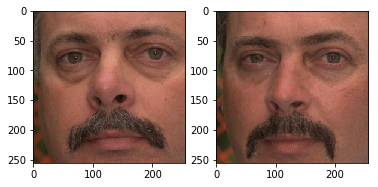

In [13]:
batch = next(iter(dataset))
fix, axs = plt.subplots(ncols=2)

axs[0].imshow(batch['A'].squeeze().numpy().transpose(1,2,0)*std+mean)
axs[1].imshow(batch['B'].squeeze().numpy().transpose(1,2,0)*std+mean)

In [14]:
dataset_size = len(dataset)    # get the number of images in the dataset.
print('The number of training images = %d' % dataset_size)

model = create_model(opt)      # create a model given opt.model and other options
model.setup(opt)               # regular setup: load and print networks; create schedulers
visualizer = Visualizer(opt)   # create a visualizer that display/save images and plots
total_iters = 0                # the total number of training iterations

The number of training images = 158


initialize network with normal
initialize network with normal
model [Pix2PixModel] was created
---------- Networks initialized -------------
[Network G] Total number of parameters : 54.414 M
[Network D] Total number of parameters : 2.769 M
-----------------------------------------------
create web directory ./_checkpoints/twins_18_pix2pix/web...


In [15]:
for epoch in range(opt.epoch_count, opt.niter + opt.niter_decay + 1):    
    epoch_start_time = time.time()  # timer for entire epoch
    iter_data_time = time.time()    # timer for data loading per iteration
    epoch_iter = 0                  # the number of training iterations in current epoch, reset to 0 every epoch

    for i, data in enumerate(dataset):  # inner loop within one epoch
        iter_start_time = time.time()  # timer for computation per iteration
        if total_iters % opt.print_freq == 0:
            t_data = iter_start_time - iter_data_time
        visualizer.reset()
        total_iters += opt.batch_size
        epoch_iter += opt.batch_size
        model.set_input(data)         # unpack data from dataset and apply preprocessing
        model.optimize_parameters()   # calculate loss functions, get gradients, update network weights

        if total_iters % opt.display_freq == 0:   # display images on visdom and save images to a HTML file
            save_result = total_iters % opt.update_html_freq == 0
            model.compute_visuals()
            visualizer.display_current_results(model.get_current_visuals(), epoch, save_result)

        if total_iters % opt.print_freq == 0:    # print training losses and save logging information to the disk
            losses = model.get_current_losses()
            t_comp = (time.time() - iter_start_time) / opt.batch_size
            visualizer.print_current_losses(epoch, epoch_iter, losses, t_comp, t_data)
            if opt.display_id > 0:
                visualizer.plot_current_losses(epoch, float(epoch_iter) / dataset_size, losses)

        if total_iters % opt.save_latest_freq == 0:   # cache our latest model every <save_latest_freq> iterations
            print('saving the latest model (epoch %d, total_iters %d)' % (epoch, total_iters))
            save_suffix = 'iter_%d' % total_iters if opt.save_by_iter else 'latest'
            model.save_networks(save_suffix)

        iter_data_time = time.time()
    if epoch % opt.save_epoch_freq == 0:              # cache our model every <save_epoch_freq> epochs
        print('saving the model at the end of epoch %d, iters %d' % (epoch, total_iters))
        model.save_networks('latest')
        model.save_networks(epoch)

    print('End of epoch %d / %d \t Time Taken: %d sec' % (epoch, opt.niter + opt.niter_decay, time.time() - epoch_start_time))
    model.update_learning_rate()                     # update learning rates at the end of every epoch.


(epoch: 1, iters: 100, time: 0.238, data: 0.008) G_GAN: 1.577 G_L1: 30.750 D_real: 0.124 D_fake: 1.030 
End of epoch 1 / 200 	 Time Taken: 15 sec
learning rate = 0.0002000
(epoch: 2, iters: 42, time: 0.244, data: 0.007) G_GAN: 4.236 G_L1: 32.665 D_real: 0.052 D_fake: 0.019 
(epoch: 2, iters: 142, time: 0.234, data: 0.007) G_GAN: 3.101 G_L1: 50.374 D_real: 0.012 D_fake: 0.306 
End of epoch 2 / 200 	 Time Taken: 14 sec
learning rate = 0.0002000
(epoch: 3, iters: 84, time: 0.267, data: 0.007) G_GAN: 4.168 G_L1: 27.247 D_real: 0.093 D_fake: 0.025 
End of epoch 3 / 200 	 Time Taken: 14 sec
learning rate = 0.0002000
(epoch: 4, iters: 26, time: 0.233, data: 0.008) G_GAN: 2.560 G_L1: 25.829 D_real: 0.036 D_fake: 0.100 


KeyboardInterrupt: 